In [16]:
using LinearAlgebra, SparseArrays
using ProgressMeter
using Plots
using LaTeXStrings
Plots.pyplot()

Plots.PyPlotBackend()

In [2]:
pressure(r, ru, rv, rE, γ=1.4) = @. (γ - 1) * (rE - (ru^2 + rv^2)/2r)

pressure (generic function with 2 methods)

In [3]:
function euler_fluxes(r, ru, rv, rE)
    p = pressure(r, ru, rv, rE)
    Frx  = ru
    Fry  = rv
    Frux = @. ru^2 / r + p
    Fruy = @. ru * rv / r
    Frvx = @. ru * rv / r
    Frvy = @. rv^2 / r + p
    FrEx = @. ru / r * (rE + p)
    FrEy = @. rv / r * (rE + p)
    return Frx, Fry, Frux, Fruy, Frvx, Frvy, FrEx, FrEy
end

euler_fluxes (generic function with 1 method)

In [4]:
function pade_x(f, h, mats)
    n = size(f)[1]
    df = zeros(n, n)

    lhs, rhs = mats
    srhs = rhs * 3 / h

    for i in 1:n
        df[:, i] = lhs \ (srhs * f[:, i])
    end
    return df
end

pade_x (generic function with 1 method)

In [5]:
"""
divF = compact_div(Fx, Fy, h)
    Computes the divergence of a field F=[Fx, Fy] using the 1d padé-scheme
"""
function compact_div(Fx, Fy, h, mats)
    dFx = pade_x(Fx, h, mats)
    dFy = pade_x(Matrix(Fy'), h, mats)
    return dFx .+ Matrix(dFy')
end

compact_div

In [6]:
function test_compact_div(n)
    h = 1 / n
    step = h:h:1
    x = repeat(step, 1, n)
    y = Matrix(x')

    mats = make_matricies(n, 0)
    mats, _ = mats

    gx = sin.(2pi .* x)
    gy = cos.(2pi .* y)
    dg = compact_div(gx, gy, h, mats)
    exact = 2pi.*(cos.(2pi.*x) .- sin.(2pi.*y)) 
    
    err = log10(maximum(abs.((exact .- dg))))
end
# println(test_compact_div(8))
println(test_compact_div(16))
println(test_compact_div(32))

println(test_compact_div(32) / test_compact_div(16))
println(test_compact_div(64) / test_compact_div(32))
# println(test_compact_div(128) / test_compact_div(64))
# println(test_compact_div(256) / test_compact_div(128))
# println(test_compact_div(512) / test_compact_div(256))

UndefVarError: UndefVarError: make_matricies not defined

In [7]:
function filter_x(u, filters)
    n = size(u)[1]  # assume square matrix
    f = zeros(n, n)
    
    lhs, rhs = filters
    
    for i = 1:n
        f[:, i] = lhs \ (rhs * u[:, i])
    end
    return f
end

filter_x (generic function with 1 method)

In [8]:
function compact_filter(u, filters)
    u = filter_x(u, filters)  # filter in x-direction
    u = filter_x(Matrix(u'), filters) # filter in y-direction
    return Matrix(u')
end

compact_filter (generic function with 1 method)

In [137]:
function test_filter()
    n = 200
    h = 1/n
    s = h:h:2pi
    x = repeat(s, 1, length(s))
    n = size(x)[1]
    y = sin.(x) 
    a = y .+ 0.003 * randn(n, 1)

    fig = plot(x[:, 1], y[:, 1], label="pure")
    plot!(x[:, 1], a[:, 1], label="noisy")
    println(error(y[:, 1], a[:, 1]))
    for p in [0.499, 0.48, 0]
        _, filter = make_matricies(n, p)
        f = compact_filter(a, filter)
        plot!(x[:, 1], f[:, 1], label="a=$(p)")
        println(error(y[:, 1], f[:, 1]))


        # f = filter_x(a, filter)
        # f2 = filter_x(Matrix(f'), filter)
        # full = compact_filter(a, filter)

        # display(a)
        # display(f)
        # display(Matrix(f2'))
        # display(full)
    end
    savefig("figs/filter_test.pdf")
end
test_filter()

0.010842438403672827
0.010676287814920249
0.009493910228303037
0.007112498729261008


In [9]:
function euler_rhs(r, ru, rv, rE, h, mats)
    Frx, Fry, Frux, Fruy, Frvx, Frvy, FrEx, FrEy = euler_fluxes(r, ru, rv, rE)
    fr  = compact_div(Frx , Fry , h, mats)
    fru = compact_div(Frux, Fruy, h, mats)
    frv = compact_div(Frvx, Frvy, h, mats)
    frE = compact_div(FrEx, FrEy, h, mats)
    return -fr, -fru, -frv, -frE
end

euler_rhs (generic function with 1 method)

In [10]:
"""
r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, alpha)
    solution u = (r, ru, rv, rE), where each element is a nxn matrix
    h: spatial stepsize
    k: temporal steplength
    alpha: filtering parameter
"""
function euler_rk4step(r, ru, rv, rE, h, k, mats)
    pade, filters = mats  # divergence and filter matricies
    k = 0.5 * k           # temporal stepsize, halved for convenience
    r1, ru1, rv1, rE1 = euler_rhs(r, ru, rv, rE, h, pade)
    r2, ru2, rv2, rE2 = euler_rhs(r+ k*r1, ru+ k*ru1, rv+ k*rv1, rE+ k*rE1, h, pade)
    r3, ru3, rv3, rE3 = euler_rhs(r+ k*r2, ru+ k*ru2, rv+ k*rv2, rE+ k*rE2, h, pade)
    r4, ru4, rv4, rE4 = euler_rhs(r+2k*r3, ru+2k*ru3, rv+2k*rv3, rE+2k*rE3, h, pade)

    r  += k/3 * (r1  + 2r2  + 2r3  + r4 )
    ru += k/3 * (ru1 + 2ru2 + 2ru3 + ru4)
    rv += k/3 * (rv1 + 2rv2 + 2rv3 + rv4)
    rE += k/3 * (rE1 + 2rE2 + 2rE3 + rE4)
    
    r  = compact_filter(r , filters)
    ru = compact_filter(ru, filters)
    rv = compact_filter(rv, filters)
    rE = compact_filter(rE, filters)
    
    return r, ru, rv, rE
end

euler_rk4step

In [11]:
function euler_vortex(x, y, time, pars)
    γ  = 1.4
    rc = pars[1]
    ϵ  = pars[2]
    M₀ = pars[3]
    θ  = pars[4]
    x₀ = pars[5]
    y₀ = pars[6]

    r∞ = 1
    u∞ = 1
    E∞ = 1/(γ*M₀^2*(γ - 1)) + 1/2
    p∞ = (γ - 1) * (E∞ - 1/2)
    ubar = u∞ * cos(θ)
    vbar = u∞ * sin(θ)
    f = @. (1 - ((x - x₀) - ubar*time)^2 - ((y - y₀) - vbar*time)^2) / rc^2

    u = @. u∞ * (cos(θ) - ϵ*((y - y₀)-vbar*time) / (2π*rc) * exp(f/2))
    v = @. u∞ * (sin(θ) + ϵ*((x - x₀)-ubar*time) / (2π*rc) * exp(f/2))
    r = @. r∞ * (1 - ϵ^2 * (γ - 1) * M₀^2/(8π^2) * exp(f))^(1/(γ-1))
    p = @. p∞ * (1 - ϵ^2 * (γ - 1) * M₀^2/(8π^2) * exp(f))^(γ/(γ-1))
    
    ru = @. r*u
    rv = @. r*v
    rE = @. p/(γ - 1) + 1/2 * (ru^2 + rv^2) / r
    
    r, ru, rv, rE
end


euler_vortex (generic function with 1 method)

In [12]:
error(x, y) = maximum(abs.(x .- y))

error (generic function with 1 method)

In [15]:
function make_matricies(n, α)
    h = 1 / n
    a = (5. / 8 + 3. * α / 4) * ones(n)
    b(n) = (α + 0.5) * ones(n) / 2
    c(n) = (α / 4. - 1/8) * ones(n) / 2

    filter_rhs = spdiagm(-n+1=>b(1), -n+2=>c(2), -2=>c(n-2), -1=>b(n-1), 0=>a, 1=>b(n-1), 2=>c(n-2), n-2=>c(2), n-1=>b(1))
    filter_lhs = spdiagm(-n+1=>[α], -1=>α*ones(n-1), 0=>ones(n), 1=>α*ones(n-1), n-1=>[α])
    
    div_lhs = spdiagm(-n+1=>[1], -1=>ones(n-1), 0=>4ones(n), 1=>ones(n-1), n-1=>[1])
    div_rhs = spdiagm(-n+1=>[1], -1=>-ones(n-1), 1=>ones(n-1), n-1=>[-1])
    
    return [[div_lhs, div_rhs], [filter_lhs, filter_rhs]]
end

make_matricies (generic function with 1 method)

In [14]:
function animate_vortex(n=32, α=0.499)
    default(legend=false)
    h = 10 / n
    T = 5sqrt(2)
    m = Int(ceil(10T / 3h))
    k = T / m

    s = h:h:10
    x = repeat(s, 1, length(s))
    y = Matrix(x')

    pars = [0.5, 1, 0.5, π/4, 2.5, 2.5]
    mats = make_matricies(n, α)

    r, ru, rv, rE = euler_vortex(x, y, 0, pars)

    l = @layout [a b; c d]
    p = plot(layout=l)

    pbar = Progress(m; showspeed=true)
    @gif for i in 1:m
        r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, mats)
        r0, ru0, rv0, rE0 = euler_vortex(x, y, i*k, pars)
        
        # println(i, size(x), size(y), size(r), size(r0), size(rE), size(rE0))
        plot!(p[1], x, y, r ,      st=:contourf, label=false, title=L"\rho")
        plot!(p[2], x, y, r0,      st=:contourf, label=false, title="true "*L"\rho")
        plot!(p[3], x, y, rE ./r , st=:contourf, label=false, title="E")
        plot!(p[4], x, y, rE0./r0, st=:contourf, label=false, title="true E")
        ProgressMeter.next!(pbar; showvalues=[(:m, m), (:current_iteration, i), (:time, i*k)])
    end every 5
end


animate_vortex (generic function with 3 methods)

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress: 100%|███████████████████████████| Time: 0:00:59 ( 1.57  s/it)


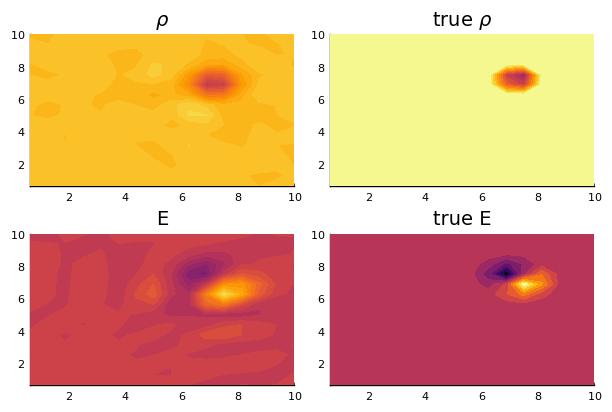

┌ Info: Saved animation to 
│   fn = /home/hakon/Documents/UiO/Berkeley2022/NumSolDiffEq/PS2/tmp.gif
└ @ Plots /home/hakon/.julia/packages/Plots/YAlrZ/src/animation.jl:114


Plots.AnimatedGif("/home/hakon/Documents/UiO/Berkeley2022/NumSolDiffEq/PS2/tmp.gif")
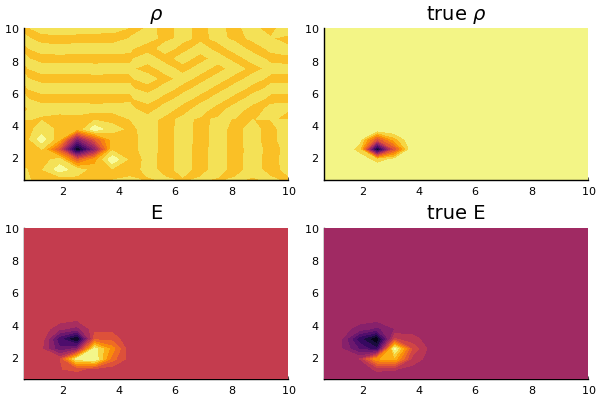

In [286]:
animate_vortex(16, 0.48)

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress: 100%|███████████████████████████| Time: 0:03:30 ( 2.77  s/it)


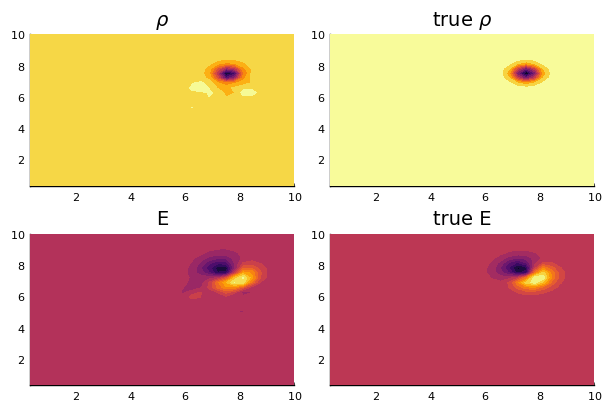

┌ Info: Saved animation to 
│   fn = /home/hakon/Documents/UiO/Berkeley2022/NumSolDiffEq/PS2/tmp.gif
└ @ Plots /home/hakon/.julia/packages/Plots/YAlrZ/src/animation.jl:114


Plots.AnimatedGif("/home/hakon/Documents/UiO/Berkeley2022/NumSolDiffEq/PS2/tmp.gif")
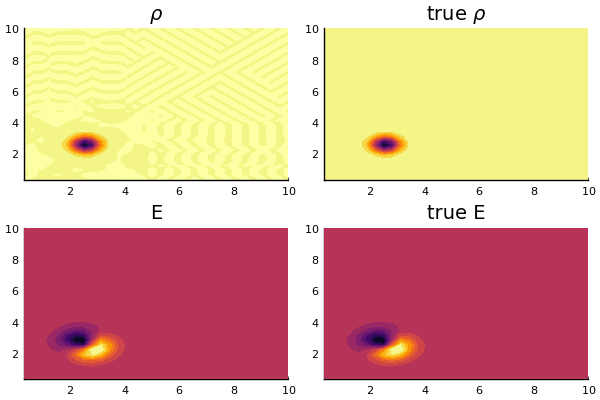

In [237]:
animate_vortex()

Progress: 100%|███████████████████████████| Time: 0:16:49 ( 6.68  s/it)


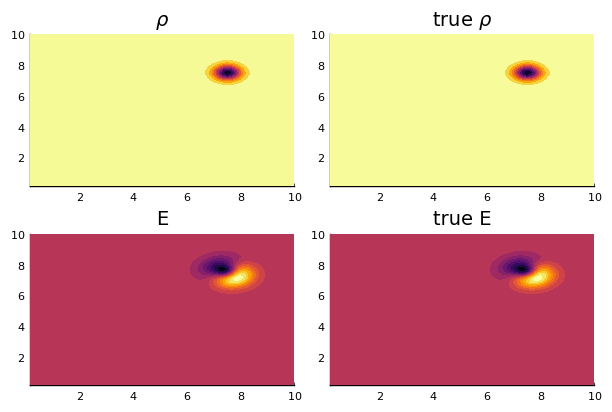

┌ Info: Saved animation to 
│   fn = /home/hakon/Documents/UiO/Berkeley2022/NumSolDiffEq/PS2/tmp.gif
└ @ Plots /home/hakon/.julia/packages/Plots/YAlrZ/src/animation.jl:114


Plots.AnimatedGif("/home/hakon/Documents/UiO/Berkeley2022/NumSolDiffEq/PS2/tmp.gif")
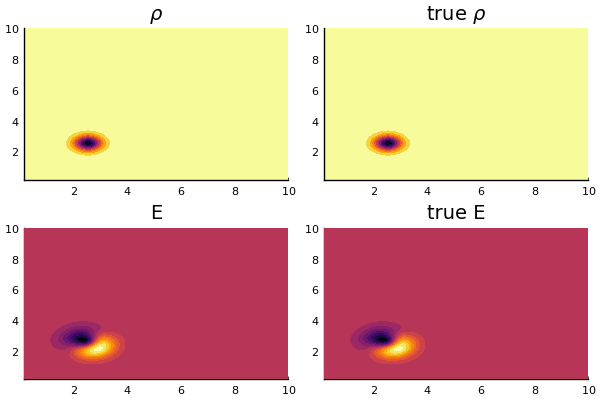

In [238]:
animate_vortex(64)

In [284]:
function test_with_vortex(n=32, α=0.499)
    # n = 32                   # points in spatial discretisation
    h = 10 / n               # spatial steplength
    T = 5sqrt(2)             # Total time
    m = Int(ceil(10T / 3h))  # points in temporal discretisation
    k = T / m                # temporal steplength

    s = h:h:10
    x = repeat(s, 1, length(s))
    y = Matrix(x')

    mats = make_matricies(n, α)

    pars = [0.5, 1, 0.5, π/4, 2.5, 2.5]
    # True solution at time T
    r0, ru0, rv0, rE0 = euler_vortex(x, y, T, pars)
    
    # initial condition
    r, ru, rv, rE = euler_vortex(x, y, 0, pars)

    pbar = Progress(m; showspeed=true)
    for i in 1:m
        r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, mats)
        ProgressMeter.next!(pbar; showvalues=[(:total_iterations, m), (:current_iteration, i), (:time, (round(i*k, digits=5)))])    
    end
    error(r, r0)
    # return r, ru, rv, rE, r0, ru0, rv0, rE0
end

test_with_vortex (generic function with 3 methods)

In [285]:
# ProgressMeter.ijulia_behavior(:clear)
@time test_with_vortex(64) # original code
# @time test_with_vortex(64) 
# @time test_with_vortex(64) 
# @time test_with_vortex(64)
# @time test_with_vortex(64) 

Progress: 100%|███████████████████████████| Time: 0:00:30 ( 0.20  s/it)
  total_iterations:   151
  current_iteration:  151
  time:               7.07107


 30.518742 seconds (23.36 M allocations: 12.095 GiB, 4.43% gc time)


0.0012309296656378699

In [254]:
function votrex_convergence(αs, ns)
    T = 5sqrt(2)
    out = []
    for α in αs
        errs = []
        hs = []

        for n in ns
            println("α=$(α), n=$(n)")
            h = 10 / n
            m = Int(ceil(10T / 3h))
            k = T / m

            s = h:h:10
            x = repeat(s, 1, length(s))
            y = Matrix(x')

            pars = [0.5, 1, 0.5, π/4, 2.5, 2.5]
            mats = make_matricies(n, α)
        
            r, ru, rv, rE = euler_vortex(x, y, 0, pars)
            pbar = Progress(m; showspeed=true)
            for i in 1:m
                r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, mats)
                ProgressMeter.next!(pbar; showvalues=[(:m, m), (:current_iteration, i), (:time, i*k)])
            end

            r0, ru0, rv0, rE0 = euler_vortex(x, y, T, pars)
            er = error(r, r0)
            eru = error(ru, ru0)
            erv = error(rv, rv0)
            erE = error(rE, rE0)
            err = maximum([er, eru, erv, erE])
            println("Maximum error was $(err)")

            push!(hs, h)
            push!(errs, err)
        end
        push!(out, [hs, errs])
    end
    return out
end

αs = [0.499, 0.48]
ns = [32, 64, 128]
data = votrex_convergence(αs, ns)

Progress: 100%|███████████████████████████| Time: 0:00:04 (54.20 ms/it)
Progress: 100%|███████████████████████████| Time: 0:00:24 ( 0.16  s/it)
Progress: 100%|███████████████████████████| Time: 0:02:34 ( 0.51  s/it)
Progress: 100%|███████████████████████████| Time: 0:00:03 (41.54 ms/it)
Progress: 100%|███████████████████████████| Time: 0:00:19 ( 0.13  s/it)
Progress: 100%|███████████████████████████| Time: 0:02:11 ( 0.44  s/it)


α=0.499, n=32
Maximum error was 0.367198662797235
α=0.499, n=64
Maximum error was 0.01740486560428689
α=0.499, n=128
Maximum error was 0.0010041467378165692
α=0.48, n=32
Maximum error was 0.30424985380919534
α=0.48, n=64
Maximum error was 0.042627292169232334
α=0.48, n=128
Maximum error was 0.004947868860219806


2-element Vector{Any}:
 Vector{Any}[[0.3125, 0.15625, 0.078125], [0.367198662797235, 0.01740486560428689, 0.0010041467378165692]]
 Vector{Any}[[0.3125, 0.15625, 0.078125], [0.30424985380919534, 0.042627292169232334, 0.004947868860219806]]

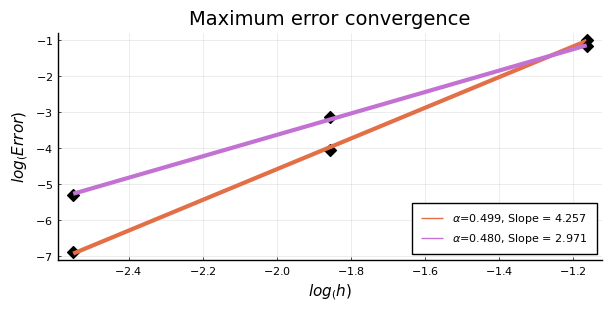

In [258]:
function vortex_convergence(αs, ns, data)
    p = plot(title="Maximum error convergence", fontsize=64, size=(600, 300))
    for i in 1:length(αs)
        α = αs[i]
        hs, errs = data[i]
        hs = log.(Float64.(hs))
        errs = log.(Float64.(errs))

        X = zeros(length(hs), 2)
        X[:, 1] .= hs
        X[:, 2] .= 1
        slope, inter = X \ errs
        plot!(hs, errs, st=:scatter, color=:black, markershapes=:diamond, markersize=6, label=false)
        plot!(hs, inter .+ slope .* hs, linewidth=3, label=L"\alpha"*"=$(rpad(α, 5, "0")), Slope = $(round(slope, digits=3))")
    end
    plot!(xlabel=L"log_(h)", ylabel=L"log_(Error)", legend=:bottomright)
    savefig("figs/vortex_convergence.pdf")
end
vortex_convergence(αs, ns, data)

In [287]:
function KelvinHelmholtz()
    T = 1
    N = 256
    h = 1 / N
    α = 0.48

    m = Int(ceil(10T / 3h))
    k = T / m

    s = h:h:1
    x = repeat(s, 1, length(s))
    y = Matrix(x')

    mats = make_matricies(N, α)

    mask = @. abs(y - 0.5) < (0.15 + sin(2pi * x) / 200) 
    r = ones(N, N)
    r[mask] .= 2
    u = r .- 1
    v = zeros(N, N)
    p = 3
    γ = 1.4
    E = @. p / ((γ - 1) * r) + (u^2 + v^2) / 2

    ru = r .* u
    rv = r .* v
    rE = r .* E

    pbar = Progress(m; showspeed=true)
    for i in 1:m
        r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, mats)
        ProgressMeter.next!(pbar; showvalues=[(:m, m), (:current_iteration, i), (:time, i*k)])
    end
    plot(x, y, r, st=:contourf)
    
end
KelvinHelmholtz()

Progress:   0%|▏                          |  ETA: 0:28:04 ( 1.98  s/it)
  m:                  854
  current_iteration:  2
  time:               0.00234192037470726

LoadError: InterruptException: